## Import Data

In [2]:
import pandas as pd

In [3]:
# Load the dataset
df = pd.read_csv('/Users/cengwenqi/Library/CloudStorage/OneDrive-UCIrvine/banksim.csv')
df.head()

Unnamed: 0 age gender           category  amount  fraud
0      171915   3      F  es_transportation   49.71      0
1      426989   4      F          es_health   39.29      0
2      310539   3      F  es_transportation   18.76      0
3      215216   4      M  es_transportation   13.95      0
4      569244   2      M  es_transportation   49.87      0

# Fraud Analysis: Simple Statistic

In [4]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
print(df.shape)
df.head()

(7200, 5)


age gender           category  amount  fraud
0   3      F  es_transportation   49.71      0
1   4      F          es_health   39.29      0
2   3      F  es_transportation   18.76      0
3   4      M  es_transportation   13.95      0
4   2      M  es_transportation   49.87      0

#### Group by transcation category

In [8]:
# Ｇroup by category and take the mean of the 'amount' and 'fraud' columns
df.groupby('category')[['amount','fraud']].mean()


amount     fraud
category                                   
es_barsandrestaurants   43.841793  0.022472
es_contents             55.170000  0.000000
es_fashion              59.780769  0.020619
es_food                 35.216050  0.000000
es_health              126.604704  0.242798
es_home                120.688317  0.208333
es_hotelservices       172.756245  0.548387
es_hyper                46.788180  0.125000
es_leisure             229.757600  1.000000
es_otherservices       149.648960  0.600000
es_sportsandtoys       157.251737  0.657895
es_tech                132.852862  0.179487
es_transportation       27.422014  0.000000
es_travel              231.818656  0.944444
es_wellnessandbeauty    66.167078  0.060606

**Insights: Based on the results, the majority of fraud is observed in travel, leisure and sports related transactions.**

#### Group by age

In [120]:
# Ｇroup by age and take the mean of the 'amount' and 'fraud' columns
df.groupby('age')[['amount','fraud']].mean()

amount     fraud
age                     
0    49.468935  0.050000
1    35.622829  0.026648
2    37.228665  0.028718
3    37.279338  0.023283
4    36.197985  0.035966
5    37.547521  0.023990
6    36.700852  0.022293
U    39.117000  0.000000

In [121]:
# Count the values of the observations in each age group
print(df['age'].value_counts())

age
2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: count, dtype: int64


**Insight: The result of the Age Group 0 is a bit different from the rest. However, the Age Group 0 only has 40 cases in the entire dataset, making it not feasible to split these out into a separate group and run the model on that amount of observations.**

#### Define Normal Behavior

In [12]:
import matplotlib.pyplot as plt

In [124]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = df.loc[df.fraud == 1] 
df_non_fraud = df.loc[df.fraud == 0]


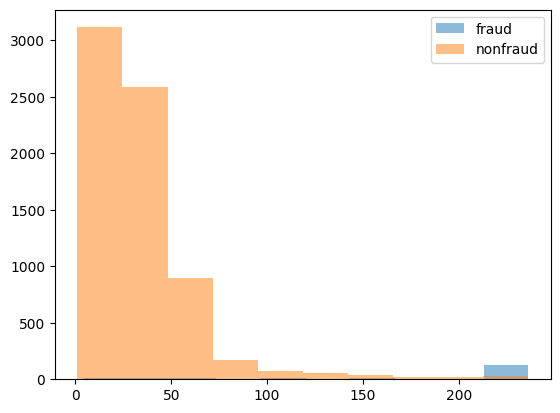

In [125]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.legend()
plt.show()

# Fraud Analysis: Clustering

## KMeans 

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np


#### Convert value to float and scale the data

**We scale the data here to prevent the results from being dominated by the majority.**

In [10]:
# Convert 'amount' column to float
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the 'amount' column
# Reshape is needed because it expects 2D array
X_scaled = scaler.fit_transform(df[['amount']])

print(X_scaled)


[[0.20681002]
 [0.16247858]
 [0.07513457]
 ...
 [1.        ]
 [1.        ]
 [1.        ]]


#### Use Elbow method to find the optimal number of cluster

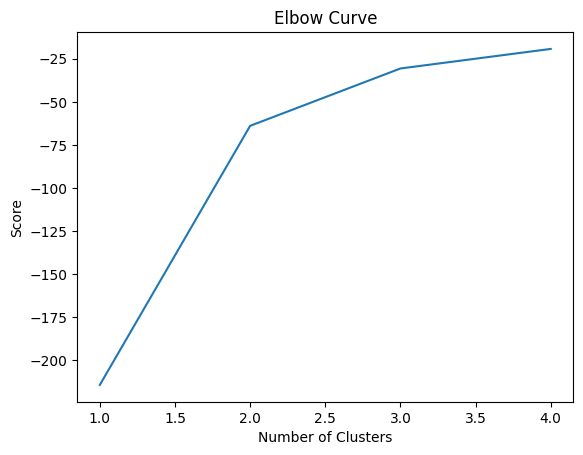

In [13]:
# Define the range of clusters to try
clustno = range(1, 5)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i, random_state=0) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**Insights: The optimal number of clusters should probably be at around 2 clusters, as that is where the elbow is in the curve.**

#### Run K-Mean model and define a cutoff point for fraud

In [133]:
# Define the variable 'y' with appropriate values
y = df['fraud']

# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [134]:
# Define K-means model
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

# Get the cluster number for each datapoint
X_test_clusters = kmeans.predict(X_test)

# Save cluster centriods
X_test_clusters_centers = kmeans.cluster_centers_


In [135]:
# Calculate the distance to the cluster centroids for each point
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create predictions based on the distance(we set the threshold to 0.85)
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 85)] = 1
km_y_pred[dist < np.percentile(dist, 85)] = 0

#### Check accuracy of catching fraud using confusion metrix

0.8763684133703109


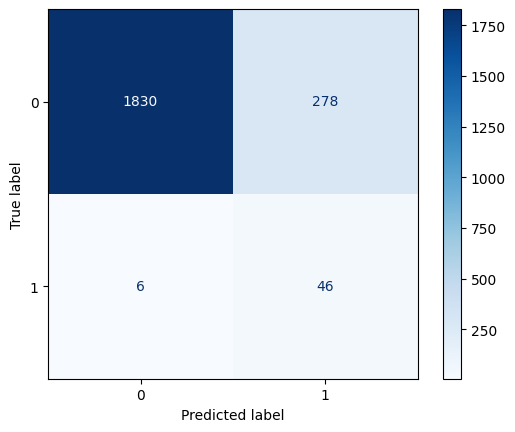

In [136]:
# Obtain the ROC score
print(roc_auc_score(y_test, km_y_pred))

# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, km_y_pred, cmap = plt.cm.Blues, normalize = None, display_labels = ['0', '1'])


## DBSCAN

In [6]:
from sklearn.cluster import DBSCAN

In [14]:
# Initialize and fit the DBSCAN model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

# Print performance metrics for DBSCAN
print('Estimated number of clusters: %d' % n_clusters)

Estimated number of clusters: 1


In [15]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

[7200]


**Insights: The presence of only one significant cluster suggests that there might not be any outliers. This indicates that fraud detection may require a more nuanced approach or the inclusion of more observations. If there is more than one cluster, the cluster with the fewest observations could indicate rare cases or potential fraud that needs further investigation.**

# Fraud Analysis: Text Mining

In [49]:
# Load the dataset
df = pd.read_csv('/Users/cengwenqi/Library/CloudStorage/OneDrive-UCIrvine/enron_emails.csv')
df.head()

Message-ID  \
0   <8345058.1075840404046.JavaMail.evans@thyme>   
1   <1512159.1075863666797.JavaMail.evans@thyme>   
2  <26118676.1075862176383.JavaMail.evans@thyme>   
3  <10369289.1075860831062.JavaMail.evans@thyme>   
4  <26728895.1075860815046.JavaMail.evans@thyme>   

                              From                               To  \
0  ('advdfeedback@investools.com')  ('advdfeedback@investools.com')   
1    ('richard.sanders@enron.com')    ('richard.sanders@enron.com')   
2            ('m..love@enron.com')            ('m..love@enron.com')   
3     ('leslie.milosevich@kp.org')     ('leslie.milosevich@kp.org')   
4     ('rtwait@graphicaljazz.com')     ('rtwait@graphicaljazz.com')   

                  Date                                            content  \
0  2002-01-29 23:20:55  INVESTools Advisory\nA Free Digest of Trusted ...   
1  2000-09-20 19:07:00  ----- Forwarded by Richard B Sanders/HOU/ECT o...   
2  2001-10-30 16:15:17  hey you are not wearing your target purple shi...   
3  2002-01-30 17:54:18  Leslie Milosevich\n1042 Santa Clara Avenue\nAl...   
4  2002-01-30 19:36:01  Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...   

                                       clean_content  
0  investools advisory free digest trusted invest...  
1  forwarded richard b sanders hou ect pm justin ...  
2  hey wearing target purple shirt today mine wan...  
3  leslie milosevich santa clara avenue alameda c...  
4  rini twait e th ave longmont co rtwait graphic...

## Word Search

#### Search for the email containing specific word

In [22]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

filtered_emails = df['clean_content'].str.contains('|'.join(searchfor), na=False) # "|" represents "OR"

# Select rows that content 'sell enron stock'
print(df.loc[filtered_emails])


                                         Message-ID  \
0      <8345058.1075840404046.JavaMail.evans@thyme>   
1      <1512159.1075863666797.JavaMail.evans@thyme>   
2     <26118676.1075862176383.JavaMail.evans@thyme>   
3     <10369289.1075860831062.JavaMail.evans@thyme>   
4     <26728895.1075860815046.JavaMail.evans@thyme>   
...                                             ...   
1151  <15875618.1075860830584.JavaMail.evans@thyme>   
1450  <30798399.1075841348382.JavaMail.evans@thyme>   
1473    <957052.1075861359136.JavaMail.evans@thyme>   
1557  <18936682.1075861158419.JavaMail.evans@thyme>   
1621   <5472336.1075841501893.JavaMail.evans@thyme>   

                                   From                                 To  \
0       ('advdfeedback@investools.com')    ('advdfeedback@investools.com')   
1         ('richard.sanders@enron.com')      ('richard.sanders@enron.com')   
2                 ('m..love@enron.com')              ('m..love@enron.com')   
3          ('leslie.milosev

#### Flag fraud based on word search

In [26]:
# Create flag variable where the emails match the searchfor terms
df['flag'] = np.where((df['clean_content'].str.contains('|'.join(searchfor)) == True), 1, 0)

# Count the values of the flag variable
count = df['flag'].value_counts()
print(count)

# total_observation = df['flag'].count()
# print(total_observation)


flag
0    1776
1     314
Name: count, dtype: int64


Message-ID  \
0   <8345058.1075840404046.JavaMail.evans@thyme>   
1   <1512159.1075863666797.JavaMail.evans@thyme>   
2  <26118676.1075862176383.JavaMail.evans@thyme>   
3  <10369289.1075860831062.JavaMail.evans@thyme>   
4  <26728895.1075860815046.JavaMail.evans@thyme>   

                              From                               To  \
0  ('advdfeedback@investools.com')  ('advdfeedback@investools.com')   
1    ('richard.sanders@enron.com')    ('richard.sanders@enron.com')   
2            ('m..love@enron.com')            ('m..love@enron.com')   
3     ('leslie.milosevich@kp.org')     ('leslie.milosevich@kp.org')   
4     ('rtwait@graphicaljazz.com')     ('rtwait@graphicaljazz.com')   

                  Date                                            content  \
0  2002-01-29 23:20:55  INVESTools Advisory\nA Free Digest of Trusted ...   
1  2000-09-20 19:07:00  ----- Forwarded by Richard B Sanders/HOU/ECT o...   
2  2001-10-30 16:15:17  hey you are not wearing your target purple shi...   
3  2002-01-30 17:54:18  Leslie Milosevich\n1042 Santa Clara Avenue\nAl...   
4  2002-01-30 19:36:01  Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...   

                                       clean_content  flag  
0  investools advisory free digest trusted invest...     1  
1  forwarded richard b sanders hou ect pm justin ...     1  
2  hey wearing target purple shirt today mine wan...     1  
3  leslie milosevich santa clara avenue alameda c...     1  
4  rini twait e th ave longmont co rtwait graphic...     1

## Text Mining

In [35]:
# Import nltk packages and string 
from nltk.corpus import stopwords
import string, nltk

from nltk.stem.wordnet import WordNetLemmatizer

In [40]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cengwenqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cengwenqi/nltk_data...


True

### Define stopwords, punctuation, and convert words to base or root

In [74]:
# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent", "ect", "u", "fwd", "www", "com"))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

# Convert words
lemma = WordNetLemmatizer()

### Clean text data

In [75]:
# Define word cleaning function
def clean(text, stop):
    text = text.rstrip()
	# Remove stopwords
    stop_free = " ".join([word for word in text.lower().split() if ((word not in stop) and (not any(char.isdigit() for char in word)))])
	# Remove punctuations
    punc_free = ''.join(word for word in stop_free if word not in exclude)
	# Lemmatize all words
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())      
    return normalized

In [76]:
text_clean=[]
for text in df['content']:
    text_clean.append(clean(text, stop).split())    


text_clean


[['investools',
  'advisory',
  'free',
  'digest',
  'trusted',
  'investment',
  'advice',
  'unsubscribe',
  'free',
  'newsletter',
  'please',
  'see',
  'below',
  'issue',
  'fried',
  'sell',
  'stock',
  'gain',
  'month',
  'km',
  'rowe',
  'january',
  'index',
  'confirms',
  'bull',
  'market',
  'aloy',
  'smallcap',
  'advisor',
  'earns',
  'lbix',
  'compounding',
  'return',
  'pine',
  'tree',
  'pcl',
  'undervalued',
  'highyield',
  'bank',
  'put',
  'customer',
  'first',
  'aso',
  'word',
  'sponsor',
  'top',
  'wall',
  'street',
  'watcher',
  'ben',
  'zacks',
  'gain',
  'moving',
  'best',
  'brightest',
  'wall',
  'street',
  'big',
  'money',
  'machine',
  'earned',
  'ben',
  'zacks',
  'fiveyear',
  'average',
  'annual',
  'gain',
  'start',
  'outperforming',
  'longterm',
  'get',
  'zacks',
  'latest',
  'buylist',
  'free',
  'trial',
  'investools',
  'advisory',
  'john',
  'brobst',
  'investoolscom',
  'fried',
  'sell',
  'stock',
  'loc

### Run Latent Dirichlet Allocation (LDA) topic model

In [77]:
import gensim
from gensim import corpora

In [78]:
# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

# Define the corpus
corpus = [dictionary.doc2bow(text) for text in text_clean]

# Print corpus and dictionary
print(dictionary)
print(corpus)

Dictionary<35902 unique tokens: ['account', 'accurate', 'acquiring', 'acre', 'address']...>
[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 6), (6, 1), (7, 2), (8, 4), (9, 1), (10, 1), (11, 1), (12, 3), (13, 2), (14, 1), (15, 4), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 3), (22, 1), (23, 1), (24, 1), (25, 5), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 3), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 4), (55, 1), (56, 1), (57, 1), (58, 1), (59, 3), (60, 1), (61, 1), (62, 4), (63, 1), (64, 8), (65, 1), (66, 5), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 12), (87, 2), (88, 2), (89, 1), (90, 1), (91, 3), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 4), (100, 1), (101,

In [79]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)
#Use gensim.models. to select the LDA model

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.011*"enron" + 0.007*"company" + 0.004*"said" + 0.004*"would" + 0.004*"u"')
(1, '0.015*"table" + 0.012*"image" + 0.011*"tr" + 0.010*"td" + 0.007*"trtd"')
(2, '0.011*"to" + 0.009*"subject" + 0.009*"please" + 0.007*"cc" + 0.006*"pm"')
(3, '0.017*"message" + 0.016*"subject" + 0.016*"to" + 0.015*"from" + 0.015*"original"')
(4, '0.017*"enron" + 0.011*"employee" + 0.010*"company" + 0.007*"stock" + 0.007*"energy"')
